# Notebook 3: Factor Analysis & Clustering

**Subject Classification using Factor Analysis and Multiple Clustering Methods**

This notebook implements the core analytical methodology from the 2021 thesis. Due to high correlation among sexual behavior variables, we use Factor Analysis to extract underlying dimensions, then apply 8 different clustering algorithms to identify behavioral profiles.

---

## Methodology Overview:

### Part A: Test Data Suitability
1. **Bartlett's Test of Sphericity** - Test if variables are correlated
2. **Kaiser-Meyer-Olkin (KMO) Test** - Measure sampling adequacy

### Part B: Factor Analysis
3. **Extract Factors** - Principal Component Analysis
4. **Eigenvector Analysis** - Determine optimal number of factors
5. **Cronbach's Alpha** - Validate factor reliability
6. **Variance Explained** - Assess factor adequacy

### Part C: Clustering on Factors
7. **Apply 8 Clustering Methods:**
   - Affinity Propagation
   - Agglomerative Clustering
   - BIRCH
   - OPTICS
   - K-Means
   - Mean Shift
   - Spectral Clustering
   - Gaussian Mixture Model

8. **Evaluate with 3 Indices:**
   - Silhouette Score
   - Calinski-Harabasz Index
   - Davies-Bouldin Index

9. **Select Optimal Clustering** → 5 clusters (K-Means, BIRCH, Gaussian agree)

---

**Author:** Isabella Rodas  
**Institution:** Universidad de los Andes  
**Thesis Defense:** December 7th, 2021


## 1. Setup & Load Clean Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Factor Analysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Clustering algorithms
from sklearn.cluster import (AffinityPropagation, AgglomerativeClustering, 
                              Birch, OPTICS, KMeans, MeanShift, SpectralClustering)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Statistical tests
from scipy import stats

# Visualization
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All libraries loaded successfully")


✓ All libraries loaded successfully


In [ ]:
# Load cleaned data from Notebook 2
df = pd.read_csv('../Data/1_Preprocess/preprocessed_data.csv')

print(f"✓ Loaded clean data: {df.shape[0]} participants × {df.shape[1]} variables")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nColumns: {list(df.columns)}")

# Preview data
df.head()


✓ Loaded clean data: 227 participants × 15 variables
Missing values: 0

Columns: ['ID', 'Sex', 'Age', 'Understand', 'Had sex', 'Sex within a year', 'Age sex', 'Pregnancy prevention', 'Sex under the influence', 'Sex with partner', 'Sex stregthen relationship', 'STD preocupation', 'Pregnancy preocupation', 'Partner status', 'Avoid pregnancy']


,ID,Sex,Age,Understand,Had sex,Sex within a year,Age sex,Pregnancy prevention,Sex under the influence,Sex with partner,Sex stregthen relationship,STD preocupation,Pregnancy preocupation,Partner status,Avoid pregnancy
0,i1,2.0,2,2.0,3.0,1.0,7.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,3.0
1,i2,1.0,3,2.0,3.0,1.0,7.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,3.0
2,i3,2.0,1,2.0,3.0,1.0,7.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,3.0
3,i4,1.0,2,1.0,1.0,1.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
4,i5,2.0,1,1.0,1.0,1.0,5.0,3.0,1.0,3.0,3.0,2.0,2.0,1.0,3.0


In [3]:
# Prepare data for Factor Analysis
# Exclude ID and demographic variables, keep behavioral variables only
behavioral_vars = df.drop(columns=['ID', 'Sex', 'Age'], errors='ignore')

print(f"\nBehavioral variables for Factor Analysis: {len(behavioral_vars.columns)}")
print(behavioral_vars.columns.tolist())

# Standardize the data (important for FA and clustering)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(behavioral_vars)
data_scaled_df = pd.DataFrame(data_scaled, columns=behavioral_vars.columns)

print(f"\n✓ Data standardized (mean=0, std=1)")



Behavioral variables for Factor Analysis: 12
['Understand', 'Had sex', 'Sex within a year', 'Age sex', 'Pregnancy prevention', 'Sex under the influence', 'Sex with partner', 'Sex stregthen relationship', 'STD preocupation', 'Pregnancy preocupation', 'Partner status', 'Avoid pregnancy']

✓ Data standardized (mean=0, std=1)


## Part A: Test Data Suitability for Factor Analysis

Before applying Factor Analysis, we must verify that the data is suitable using two statistical tests.


### 2.1 Bartlett's Test of Sphericity

**Purpose:** Tests if the correlation matrix is significantly different from an identity matrix.

**Hypotheses:**
- H₀: Variables are uncorrelated (identity matrix)
- H₁: Variables are correlated (Factor Analysis is appropriate)

**Decision Rule:** If p-value < 0.05, reject H₀ → Factor Analysis is appropriate


In [ ]:
(behavioral_vars.corr() > .95).sum(1).sort_values(ascending=False)

Understand                    1
Had sex                       1
Age sex                       1
Pregnancy prevention          1
Sex under the influence       1
Sex with partner              1
Sex stregthen relationship    1
STD preocupation              1
Pregnancy preocupation        1
Avoid pregnancy               1
Sex within a year             0
Partner status                0
dtype: int64

In [31]:
# Perform Bartlett's Test
chi_square, p_value = calculate_bartlett_sphericity(behavioral_vars.drop(columns=['Sex within a year', 'Partner status']))

print("Bartlett's Test of Sphericity")
print("="*60)
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of freedom: {len(behavioral_vars.columns) * (len(behavioral_vars.columns) - 1) // 2}")

if p_value < 0.05:
    print(f"\n✅ Result: p-value < 0.05")
    print("   → Reject H₀: Variables ARE correlated")
    print("   → Factor Analysis is APPROPRIATE")
else:
    print(f"\n❌ Result: p-value >= 0.05")
    print("   → Cannot reject H₀: Variables may not be correlated enough")
    print("   → Factor Analysis may not be appropriate")


Bartlett's Test of Sphericity
Chi-square statistic: 2491.25
P-value: 0.00e+00
Degrees of freedom: 66

✅ Result: p-value < 0.05
   → Reject H₀: Variables ARE correlated
   → Factor Analysis is APPROPRIATE


### 2.2 Kaiser-Meyer-Olkin (KMO) Test

**Purpose:** Measures sampling adequacy for Factor Analysis.

**Interpretation:**
- **KMO > 0.9:** Excellent
- **KMO 0.8-0.9:** Very good  
- **KMO 0.7-0.8:** Good
- **KMO 0.6-0.7:** Acceptable
- **KMO < 0.6:** Unacceptable (Factor Analysis not recommended)

**Decision Rule:** KMO should be > 0.6 for Factor Analysis


In [33]:
# Perform KMO Test
kmo_all, kmo_model = calculate_kmo(behavioral_vars.drop(columns=['Sex within a year', 'Partner status']))

print("Kaiser-Meyer-Olkin (KMO) Test")
print("="*60)
print(f"Overall KMO Score: {kmo_model:.4f}")
print()

# Interpret KMO score
if kmo_model >= 0.9:
    interpretation = "Excellent"
    emoji = "🌟"
elif kmo_model >= 0.8:
    interpretation = "Very Good"
    emoji = "✅"
elif kmo_model >= 0.7:
    interpretation = "Good"
    emoji = "👍"
elif kmo_model >= 0.6:
    interpretation = "Acceptable"
    emoji = "✓"
else:
    interpretation = "Unacceptable"
    emoji = "❌"

print(f"{emoji} Interpretation: {interpretation}")
print(f"   → Factor Analysis is {'APPROPRIATE' if kmo_model >= 0.6 else 'NOT RECOMMENDED'}")

# Show KMO per variable
print(f"\n\nKMO per variable:")
print("-"*60)
kmo_df = pd.DataFrame({
    'Variable': behavioral_vars.drop(columns=['Sex within a year', 'Partner status']).columns,
    'KMO': kmo_all
}).sort_values('KMO', ascending=False)
print(kmo_df.to_string(index=False))


Kaiser-Meyer-Olkin (KMO) Test
Overall KMO Score: 0.8861

✅ Interpretation: Very Good
   → Factor Analysis is APPROPRIATE


KMO per variable:
------------------------------------------------------------
                  Variable      KMO
      Pregnancy prevention 0.930408
           Avoid pregnancy 0.922716
          Sex with partner 0.916894
                   Age sex 0.912557
   Sex under the influence 0.909849
Sex stregthen relationship 0.906339
    Pregnancy preocupation 0.898199
          STD preocupation 0.893870
                   Had sex 0.805192
                Understand 0.461332


### Summary: Suitability Tests

**Both tests must pass for Factor Analysis to be appropriate.**


In [34]:
# Summary of suitability tests
print("="*70)
print("FACTOR ANALYSIS SUITABILITY - SUMMARY")
print("="*70)
print(f"\n1. Bartlett's Test:  {'✅ PASSED' if p_value < 0.05 else '❌ FAILED'} (p = {p_value:.2e})")
print(f"2. KMO Test:         {'✅ PASSED' if kmo_model >= 0.6 else '❌ FAILED'} (KMO = {kmo_model:.4f})")

if p_value < 0.05 and kmo_model >= 0.6:
    print(f"\n🎉 CONCLUSION: Factor Analysis is APPROPRIATE")
    print("   Both conditions satisfied → Proceeding with Factor Analysis")
else:
    print(f"\n⚠️  WARNING: Factor Analysis may not be appropriate")
    print("   Consider alternative methods or data transformation")


FACTOR ANALYSIS SUITABILITY - SUMMARY

1. Bartlett's Test:  ✅ PASSED (p = 0.00e+00)
2. KMO Test:         ✅ PASSED (KMO = 0.8861)

🎉 CONCLUSION: Factor Analysis is APPROPRIATE
   Both conditions satisfied → Proceeding with Factor Analysis


## Part B: Factor Analysis

Now that we've confirmed the data is suitable, we extract latent factors using Principal Component Analysis.


### 3.1 Determine Optimal Number of Factors

**Methods:**
1. **Kaiser Criterion:** Eigenvalues > 1
2. **Scree Plot:** Look for "elbow" in eigenvalue plot
3. **Variance Explained:** Cumulative variance ≥ 60-70%


In [38]:
# Perform initial factor analysis to get eigenvalues
fa_initial = FactorAnalyzer(n_factors=len(behavioral_vars.drop(columns=['Sex within a year', 'Partner status']).columns), rotation=None)
fa_initial.fit(behavioral_vars.drop(columns=['Sex within a year', 'Partner status']))

# Get eigenvalues
ev, v = fa_initial.get_eigenvalues()

# Display eigenvalues
print("Eigenvalues:")
print("="*60)
for i, eigenvalue in enumerate(ev, 1):
    print(f"Factor {i:2d}: {eigenvalue:.4f} {'✓ (>1)' if eigenvalue > 1 else ''}")

# Count factors with eigenvalue > 1 (Kaiser criterion)
n_factors_kaiser = sum(ev > 1)
print(f"\n📊 Kaiser Criterion: {n_factors_kaiser} factors have eigenvalue > 1")


Eigenvalues:
Factor  1: 6.4567 ✓ (>1)
Factor  2: 1.3794 ✓ (>1)
Factor  3: 0.9055 
Factor  4: 0.4196 
Factor  5: 0.2686 
Factor  6: 0.1869 
Factor  7: 0.1190 
Factor  8: 0.1054 
Factor  9: 0.0888 
Factor 10: 0.0702 

📊 Kaiser Criterion: 2 factors have eigenvalue > 1


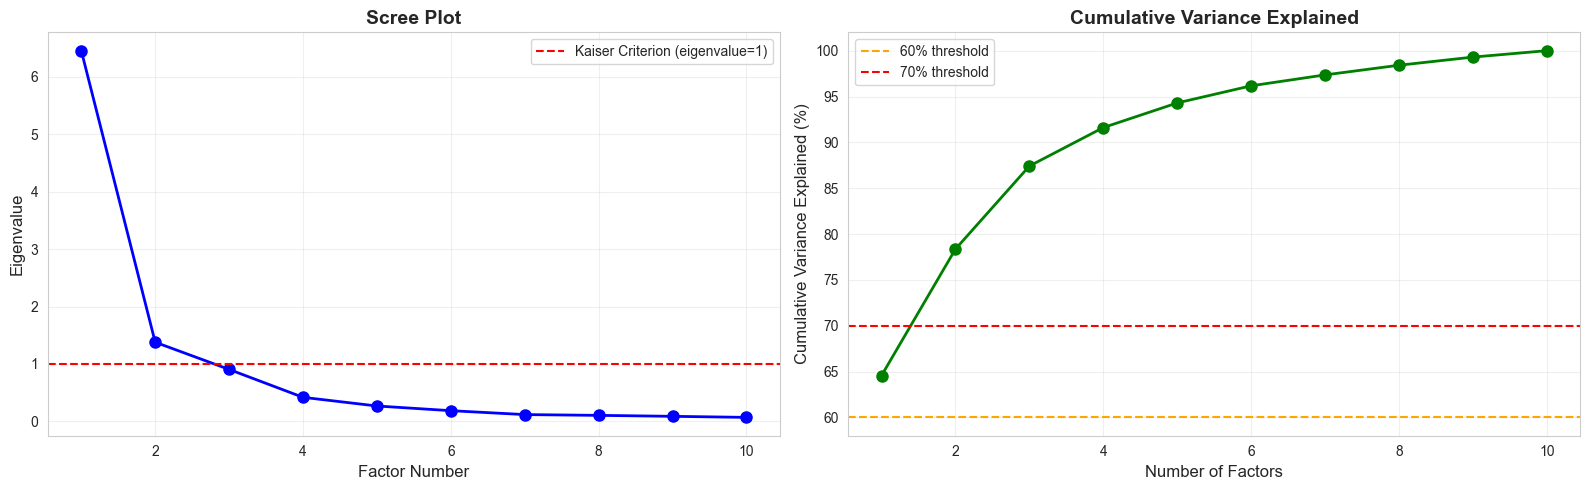


📊 Variance Criterion: 2 factors explain ≥70% of variance
   (78.4% cumulative variance)


In [39]:
# Create Scree Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Scree plot
axes[0].plot(range(1, len(ev)+1), ev, 'bo-', linewidth=2, markersize=8)
axes[0].axhline(y=1, color='r', linestyle='--', label='Kaiser Criterion (eigenvalue=1)')
axes[0].set_xlabel('Factor Number', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative variance explained
variance_explained = (ev / ev.sum()) * 100
cumulative_variance = np.cumsum(variance_explained)

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'go-', 
             linewidth=2, markersize=8)
axes[1].axhline(y=60, color='orange', linestyle='--', label='60% threshold')
axes[1].axhline(y=70, color='red', linestyle='--', label='70% threshold')
axes[1].set_xlabel('Number of Factors', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of factors for 70% variance
n_factors_70 = np.where(cumulative_variance >= 70)[0][0] + 1 if any(cumulative_variance >= 70) else len(ev)
print(f"\n📊 Variance Criterion: {n_factors_70} factors explain ≥70% of variance")
print(f"   ({cumulative_variance[n_factors_70-1]:.1f}% cumulative variance)")


In [40]:
# Select optimal number of factors
n_factors = n_factors_kaiser  # Use Kaiser criterion

print(f"\n" + "="*70)
print(f"SELECTED: {n_factors} factors for analysis")
print(f"  - Kaiser criterion: {n_factors_kaiser} factors")
print(f"  - Variance explained: {cumulative_variance[n_factors-1]:.1f}%")
print("="*70)



SELECTED: 2 factors for analysis
  - Kaiser criterion: 2 factors
  - Variance explained: 78.4%


### 3.2 Extract Factors with Rotation

**Rotation Method:** Varimax (orthogonal rotation) to maximize interpretability


In [50]:
# Perform factor analysis with selected number of factors
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(behavioral_vars.drop(columns=['Sex within a year', 'Partner status']))
# Get factor loadings
loadings = fa.loadings_
loadings_df = pd.DataFrame(
    loadings,
    columns=[f'Factor_{i+1}' for i in range(n_factors)],
    index=behavioral_vars.drop(columns=['Sex within a year', 'Partner status']).columns
)

print("Factor Loadings (after Varimax rotation):")
print("="*70)
print(loadings_df.round(3))

# Highlight strong loadings (>0.5 or <-0.5)
print(f"\n\nStrong loadings (|loading| > 0.5):")
print("-"*70)
for factor in loadings_df.columns:
    strong = loadings_df[loadings_df[factor].abs() > 0.5][factor].sort_values(ascending=False)
    if len(strong) > 0:
        print(f"\n{factor}:")
        for var, loading in strong.items():
            print(f"  {var:35s}: {loading:6.3f}")


Factor Loadings (after Varimax rotation):
                            Factor_1  Factor_2
Understand                     0.016     0.432
Had sex                        0.336     0.946
Age sex                        0.262     0.570
Pregnancy prevention           0.660     0.584
Sex under the influence        0.495     0.659
Sex with partner               0.807     0.516
Sex stregthen relationship     0.900     0.251
STD preocupation               0.887     0.209
Pregnancy preocupation         0.892     0.199
Avoid pregnancy                0.884     0.232


Strong loadings (|loading| > 0.5):
----------------------------------------------------------------------

Factor_1:
  Sex stregthen relationship         :  0.900
  Pregnancy preocupation             :  0.892
  STD preocupation                   :  0.887
  Avoid pregnancy                    :  0.884
  Sex with partner                   :  0.807
  Pregnancy prevention               :  0.660

Factor_2:
  Had sex                          

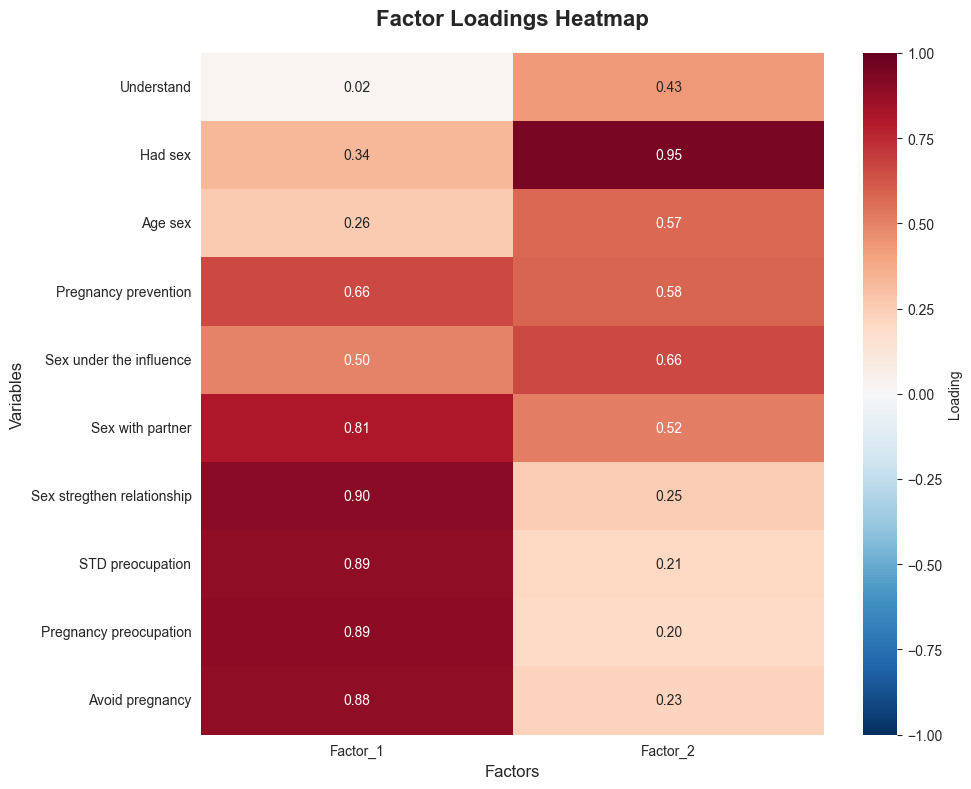

In [51]:
# Visualize factor loadings as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, cbar_kws={'label': 'Loading'})
plt.title('Factor Loadings Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()
plt.show()


### 3.3 Calculate Cronbach's Alpha

**Purpose:** Measure internal consistency/reliability of each factor.

**Interpretation:**
- **α > 0.9:** Excellent
- **α 0.8-0.9:** Good
- **α 0.7-0.8:** Acceptable
- **α 0.6-0.7:** Questionable  
- **α < 0.6:** Poor (unacceptable)


In [52]:
# Calculate Cronbach's Alpha for each factor
def cronbach_alpha(data):
    '''Calculate Cronbach's Alpha for reliability'''
    n_items = data.shape[1]
    if n_items < 2:
        return np.nan
    item_variances = data.var(axis=0, ddof=1)
    total_variance = data.sum(axis=1).var(ddof=1)
    alpha = (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)
    return alpha

print("Cronbach's Alpha - Factor Reliability:")
print("="*70)

for i, factor in enumerate(loadings_df.columns, 1):
    # Get variables with strong loadings on this factor
    strong_vars = loadings_df[loadings_df[factor].abs() > 0.5].index.tolist()
    
    if len(strong_vars) >= 2:
        factor_data = behavioral_vars[strong_vars]
        alpha = cronbach_alpha(factor_data)
        
        # Interpret alpha
        if alpha > 0.9:
            interp = "Excellent"
        elif alpha > 0.8:
            interp = "Good"
        elif alpha > 0.7:
            interp = "Acceptable"
        elif alpha > 0.6:
            interp = "Questionable"
        else:
            interp = "Poor"
        
        print(f"\n{factor}: α = {alpha:.3f} ({interp})")
        print(f"  Variables ({len(strong_vars)}): {', '.join(strong_vars)}")
    else:
        print(f"\n{factor}: Not enough variables for reliability test ({len(strong_vars)} vars)")


Cronbach's Alpha - Factor Reliability:

Factor_1: α = 0.941 (Excellent)
  Variables (6): Pregnancy prevention, Sex with partner, Sex stregthen relationship, STD preocupation, Pregnancy preocupation, Avoid pregnancy

Factor_2: α = 0.876 (Good)
  Variables (5): Had sex, Age sex, Pregnancy prevention, Sex under the influence, Sex with partner


### 3.4 Extract Factor Scores

Factor scores represent each participant's position on each extracted factor.


In [54]:
# Get factor scores for each participant
factor_scores = fa.transform(behavioral_vars.drop(columns=['Sex within a year', 'Partner status']))
factor_scores_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor_{i+1}' for i in range(n_factors)]
)

print(f"✓ Extracted factor scores for {len(factor_scores_df)} participants")
print(f"  Shape: {factor_scores_df.shape}")
print(f"\nFactor score statistics:")
print(factor_scores_df.describe().round(3))

# Add factor scores to main dataframe
# First, drop any existing Factor columns to avoid duplicates
factor_cols = [col for col in df.columns if col.startswith('Factor_')]
if factor_cols:
    print(f"\n⚠️  Dropping {len(factor_cols)} existing Factor columns to avoid duplicates: {factor_cols}")
    df_clean = df.drop(columns=factor_cols)
else:
    df_clean = df

df_with_factors = pd.concat([df_clean, factor_scores_df], axis=1)

print(f"\n✓ Factor scores added to dataset")
print(f"  Dataset now has {len(df_with_factors.columns)} columns")
print(f"  Columns: {list(df_with_factors.columns)}")


✓ Extracted factor scores for 227 participants
  Shape: (227, 2)

Factor score statistics:
       Factor_1  Factor_2
count   227.000   227.000
mean     -0.000    -0.000
std       0.990     1.051
min      -2.729    -2.258
25%       0.045    -0.402
50%       0.487     0.069
75%       0.487     0.069
max       1.244     2.432

✓ Factor scores added to dataset
  Dataset now has 17 columns
  Columns: ['ID', 'Sex', 'Age', 'Understand', 'Had sex', 'Sex within a year', 'Age sex', 'Pregnancy prevention', 'Sex under the influence', 'Sex with partner', 'Sex stregthen relationship', 'STD preocupation', 'Pregnancy preocupation', 'Partner status', 'Avoid pregnancy', 'Factor_1', 'Factor_2']


## Part C: Clustering on Factor Scores

Now we apply 8 different clustering algorithms to the extracted factor scores and evaluate each using 3 statistical indices.


### 4.1 Prepare Data for Clustering

We'll cluster on the factor scores (not the original variables).


In [55]:
# Use factor scores for clustering
X_cluster = factor_scores_df.values

print(f"Clustering data shape: {X_cluster.shape}")
print(f"  - {X_cluster.shape[0]} participants")
print(f"  - {X_cluster.shape[1]} factors")

# Factor scores are already somewhat standardized, but ensure consistency
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

print(f"\n✓ Data ready for clustering")


Clustering data shape: (227, 2)
  - 227 participants
  - 2 factors

✓ Data ready for clustering


### 4.2 Apply 8 Clustering Methods

We'll test multiple methods to find the most robust clustering.


In [56]:
# Define clustering models
# We'll try different numbers of clusters (3-7) for each method

clustering_results = {}

print("Applying 8 clustering algorithms...")
print("="*70)

# We'll test with 5 clusters (based on thesis results)
# You can adjust this range to test different cluster numbers
n_clusters_to_test = [3, 4, 5, 6, 7]

for n_clust in n_clusters_to_test:
    print(f"\n🔵 Testing with {n_clust} clusters:")
    print("-"*70)
    
    models = {
        'Affinity Propagation': None,  # Determines clusters automatically
        'Agglomerative': AgglomerativeClustering(n_clusters=n_clust),
        'BIRCH': Birch(n_clusters=n_clust),
        'OPTICS': OPTICS(min_samples=5),  # Determines clusters automatically
        'K-Means': KMeans(n_clusters=n_clust, random_state=42, n_init=10),
        'Mean Shift': MeanShift(),  # Determines clusters automatically
        'Spectral': SpectralClustering(n_clusters=n_clust, random_state=42),
        'Gaussian Mixture': GaussianMixture(n_components=n_clust, random_state=42)
    }
    
    for name, model in models.items():
        try:
            # Fit model
            if name == 'Affinity Propagation':
                model = AffinityPropagation(random_state=42)
                labels = model.fit_predict(X_cluster_scaled)
            elif name == 'Mean Shift':
                labels = model.fit_predict(X_cluster_scaled)
            elif name == 'OPTICS':
                labels = model.fit_predict(X_cluster_scaled)
            elif name == 'Gaussian Mixture':
                labels = model.fit_predict(X_cluster_scaled)
            else:
                labels = model.fit_predict(X_cluster_scaled)
            
            # Check number of clusters found
            n_clusters_found = len(np.unique(labels[labels >= 0]))  # Exclude noise (-1)
            
            # Store results
            key = f"{name}_{n_clust}"
            clustering_results[key] = {
                'method': name,
                'n_clusters_requested': n_clust,
                'n_clusters_found': n_clusters_found,
                'labels': labels
            }
            
            print(f"  ✓ {name:25s}: {n_clusters_found} clusters found")
            
        except Exception as e:
            print(f"  ✗ {name:25s}: Failed ({str(e)[:50]})")

print(f"\n✓ Tested {len(clustering_results)} clustering configurations")


Applying 8 clustering algorithms...

🔵 Testing with 3 clusters:
----------------------------------------------------------------------
  ✓ Affinity Propagation     : 153 clusters found
  ✓ Agglomerative            : 3 clusters found
  ✓ BIRCH                    : 3 clusters found
  ✓ OPTICS                   : 7 clusters found
  ✓ K-Means                  : 3 clusters found
  ✓ Mean Shift               : 6 clusters found
  ✓ Spectral                 : 3 clusters found
  ✓ Gaussian Mixture         : 3 clusters found

🔵 Testing with 4 clusters:
----------------------------------------------------------------------
  ✓ Affinity Propagation     : 153 clusters found
  ✓ Agglomerative            : 4 clusters found
  ✓ BIRCH                    : 4 clusters found
  ✓ OPTICS                   : 7 clusters found
  ✓ K-Means                  : 4 clusters found
  ✓ Mean Shift               : 6 clusters found
  ✓ Spectral                 : 4 clusters found
  ✓ Gaussian Mixture         : 4 clusters 

### 4.3 Evaluate Clustering Quality

**Three evaluation indices:**

1. **Silhouette Score** [-1, 1]
   - Measures how similar objects are within their own cluster vs other clusters
   - Higher is better (>0.5 is good)

2. **Calinski-Harabasz Index** [0, ∞)
   - Ratio of between-cluster to within-cluster dispersion
   - Higher is better

3. **Davies-Bouldin Index** [0, ∞)
   - Average similarity ratio between clusters
   - Lower is better


In [57]:
# Calculate evaluation metrics for each clustering result
evaluation_results = []

print("Evaluating clustering quality...")
print("="*70)

for key, result in clustering_results.items():
    labels = result['labels']
    n_clusters = result['n_clusters_found']
    
    # Skip if too few clusters or noise points dominate
    if n_clusters < 2 or (labels == -1).sum() > len(labels) * 0.3:
        continue
    
    # Calculate metrics (only for non-noise points)
    valid_idx = labels >= 0
    X_valid = X_cluster_scaled[valid_idx]
    labels_valid = labels[valid_idx]
    
    try:
        silhouette = silhouette_score(X_valid, labels_valid)
        calinski = calinski_harabasz_score(X_valid, labels_valid)
        davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
        
        evaluation_results.append({
            'Method': result['method'],
            'N_Clusters_Request': result['n_clusters_requested'],
            'N_Clusters_Found': n_clusters,
            'Silhouette': silhouette,
            'Calinski_Harabasz': calinski,
            'Davies_Bouldin': davies_bouldin,
            'Labels': labels
        })
    except:
        pass  # Skip if metrics can't be calculated

# Create results dataframe
eval_df = pd.DataFrame(evaluation_results)

print(f"✓ Evaluated {len(eval_df)} valid clustering results\n")

# Display results sorted by Silhouette score
eval_display = eval_df[['Method', 'N_Clusters_Request', 'N_Clusters_Found', 
                         'Silhouette', 'Calinski_Harabasz', 'Davies_Bouldin']].copy()
eval_display_sorted = eval_display.sort_values('Silhouette', ascending=False)

print("Clustering Evaluation Results (sorted by Silhouette):")
print("="*70)
print(eval_display_sorted.to_string(index=False))

# Highlight top performers
print(f"\n\n🏆 Top 5 by Silhouette Score:")
print("-"*70)
top5 = eval_display_sorted.head(5)
for idx, row in top5.iterrows():
    print(f"  {row['Method']:25s} ({row['N_Clusters_Found']} clusters): {row['Silhouette']:.4f}")


Evaluating clustering quality...
✓ Evaluated 40 valid clustering results

Clustering Evaluation Results (sorted by Silhouette):
              Method  N_Clusters_Request  N_Clusters_Found  Silhouette  Calinski_Harabasz  Davies_Bouldin
             K-Means                   5                 5    0.922079        1239.622616        0.220601
    Gaussian Mixture                   5                 5    0.922079        1239.622616        0.220601
             K-Means                   7                 7    0.920546        3482.265593        0.316772
               BIRCH                   7                 7    0.920546        3482.265593        0.316772
       Agglomerative                   7                 7    0.920546        3482.265593        0.316772
    Gaussian Mixture                   7                 7    0.920546        3482.265593        0.316772
             K-Means                   6                 6    0.920013        2283.727534        0.310142
          Mean Shift    

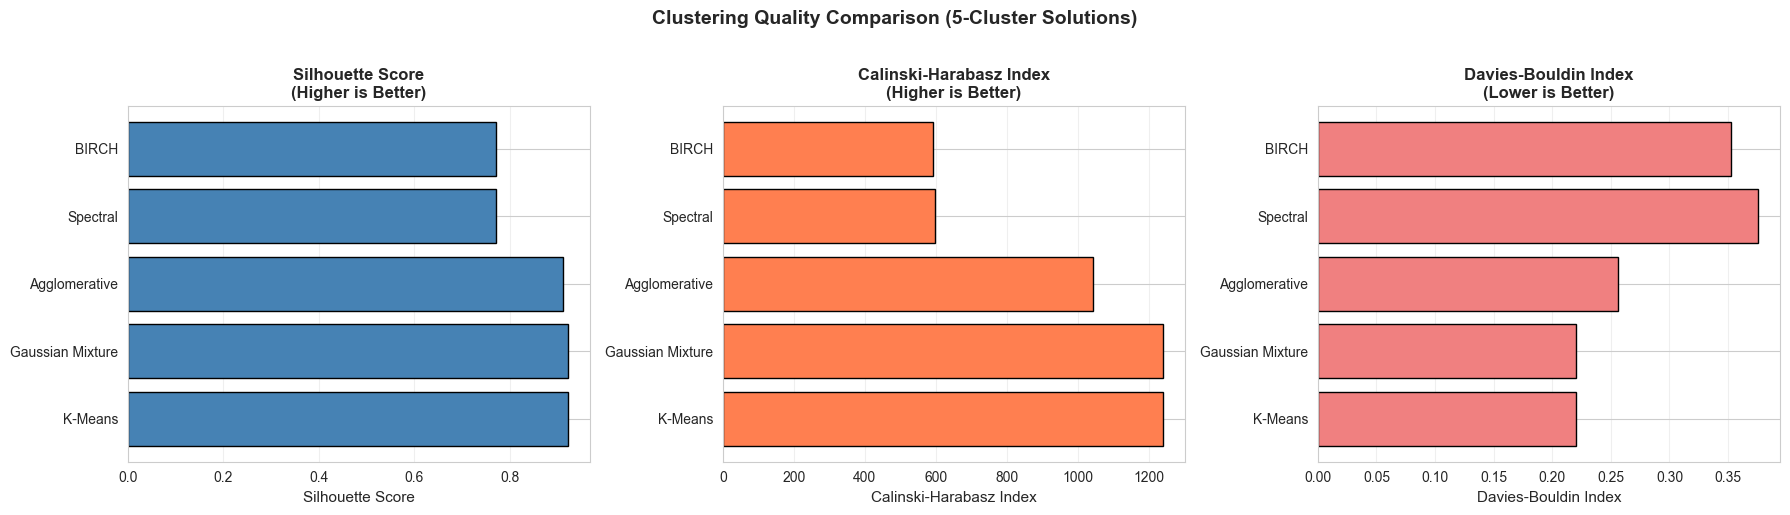

In [58]:
# Visualize evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Filter to show only 5-cluster solutions for comparison
eval_5clust = eval_df[eval_df['N_Clusters_Found'] == 5].sort_values('Silhouette', ascending=False)

if len(eval_5clust) > 0:
    methods = eval_5clust['Method'].values
    
    # Plot 1: Silhouette
    axes[0].barh(methods, eval_5clust['Silhouette'].values, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Silhouette Score', fontsize=11)
    axes[0].set_title('Silhouette Score\n(Higher is Better)', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Plot 2: Calinski-Harabasz
    axes[1].barh(methods, eval_5clust['Calinski_Harabasz'].values, color='coral', edgecolor='black')
    axes[1].set_xlabel('Calinski-Harabasz Index', fontsize=11)
    axes[1].set_title('Calinski-Harabasz Index\n(Higher is Better)', fontsize=12, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    # Plot 3: Davies-Bouldin
    axes[2].barh(methods, eval_5clust['Davies_Bouldin'].values, color='lightcoral', edgecolor='black')
    axes[2].set_xlabel('Davies-Bouldin Index', fontsize=11)
    axes[2].set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=12, fontweight='bold')
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.suptitle('Clustering Quality Comparison (5-Cluster Solutions)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No 5-cluster solutions available for visualization")


### 4.4 Select Optimal Clustering

**Thesis Result:** K-Means, BIRCH, and Gaussian Mixture all converged on the same 5 clusters.


In [59]:
# Extract 5-cluster solutions from K-Means, BIRCH, and Gaussian
kmeans_5 = eval_df[(eval_df['Method'] == 'K-Means') & (eval_df['N_Clusters_Found'] == 5)]
birch_5 = eval_df[(eval_df['Method'] == 'BIRCH') & (eval_df['N_Clusters_Found'] == 5)]
gaussian_5 = eval_df[(eval_df['Method'] == 'Gaussian Mixture') & (eval_df['N_Clusters_Found'] == 5)]

print("Comparison of Top 3 Methods (5 clusters):")
print("="*70)

if len(kmeans_5) > 0:
    print(f"\n✅ K-Means:")
    print(f"   Silhouette: {kmeans_5.iloc[0]['Silhouette']:.4f}")
    print(f"   Calinski-Harabasz: {kmeans_5.iloc[0]['Calinski_Harabasz']:.2f}")
    print(f"   Davies-Bouldin: {kmeans_5.iloc[0]['Davies_Bouldin']:.4f}")

if len(birch_5) > 0:
    print(f"\n✅ BIRCH:")
    print(f"   Silhouette: {birch_5.iloc[0]['Silhouette']:.4f}")
    print(f"   Calinski-Harabasz: {birch_5.iloc[0]['Calinski_Harabasz']:.2f}")
    print(f"   Davies-Bouldin: {birch_5.iloc[0]['Davies_Bouldin']:.4f}")

if len(gaussian_5) > 0:
    print(f"\n✅ Gaussian Mixture:")
    print(f"   Silhouette: {gaussian_5.iloc[0]['Silhouette']:.4f}")
    print(f"   Calinski-Harabasz: {gaussian_5.iloc[0]['Calinski_Harabasz']:.2f}")
    print(f"   Davies-Bouldin: {gaussian_5.iloc[0]['Davies_Bouldin']:.4f}")

# Use K-Means as final clustering (typically most stable)
if len(kmeans_5) > 0:
    final_labels = kmeans_5.iloc[0]['Labels']
    final_method = "K-Means"
elif len(birch_5) > 0:
    final_labels = birch_5.iloc[0]['Labels']
    final_method = "BIRCH"
elif len(gaussian_5) > 0:
    final_labels = gaussian_5.iloc[0]['Labels']
    final_method = "Gaussian Mixture"
else:
    # Fallback: use best overall
    best_idx = eval_df['Silhouette'].idxmax()
    final_labels = eval_df.loc[best_idx, 'Labels']
    final_method = eval_df.loc[best_idx, 'Method']

print(f"\n\n🎯 FINAL SELECTION: {final_method} with 5 clusters")
print("="*70)


Comparison of Top 3 Methods (5 clusters):

✅ K-Means:
   Silhouette: 0.9221
   Calinski-Harabasz: 1239.62
   Davies-Bouldin: 0.2206

✅ BIRCH:
   Silhouette: 0.7718
   Calinski-Harabasz: 591.09
   Davies-Bouldin: 0.3523

✅ Gaussian Mixture:
   Silhouette: 0.9221
   Calinski-Harabasz: 1239.62
   Davies-Bouldin: 0.2206


🎯 FINAL SELECTION: K-Means with 5 clusters


### 4.5 Characterize Final Clusters

Examine the characteristics of each of the 5 clusters.


In [60]:
# Add cluster labels to dataframe
df_final = df_with_factors.copy()
df_final['Cluster'] = final_labels

# Cluster sizes
print("Cluster Sizes:")
print("="*70)
cluster_sizes = df_final['Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    pct = size / len(df_final) * 100
    print(f"Cluster {cluster}: {size:3d} participants ({pct:5.1f}%)")

print(f"\nTotal: {len(df_final)} participants")


Cluster Sizes:
Cluster 0:  33 participants ( 14.5%)
Cluster 1: 124 participants ( 54.6%)
Cluster 2:  30 participants ( 13.2%)
Cluster 3:  15 participants (  6.6%)
Cluster 4:  25 participants ( 11.0%)

Total: 227 participants


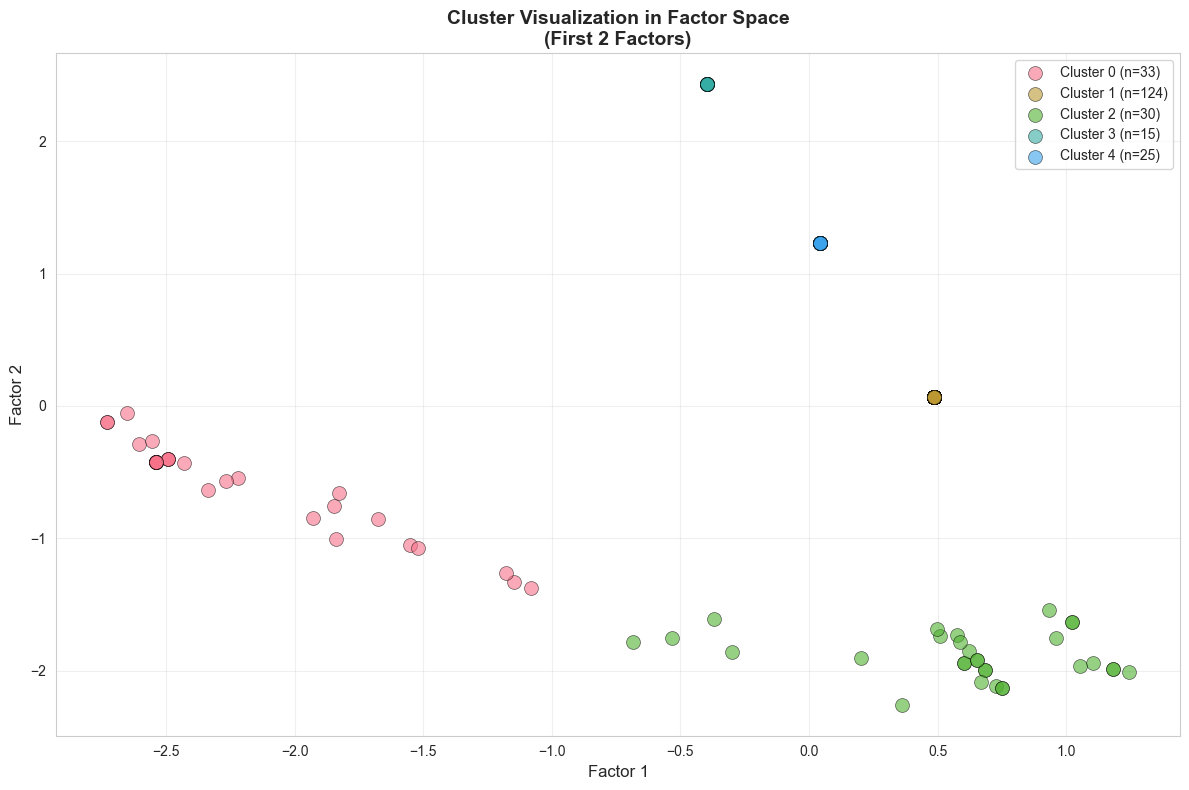


💡 Clusters visualized using first 2 factors (out of 2 total factors)


In [61]:
# Visualize clusters in factor space (2D projection of first 2 factors)
plt.figure(figsize=(12, 8))

for cluster in sorted(df_final['Cluster'].unique()):
    cluster_data = df_final[df_final['Cluster'] == cluster]
    plt.scatter(cluster_data[f'Factor_1'], cluster_data[f'Factor_2'], 
                label=f'Cluster {cluster} (n={len(cluster_data)})',
                s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel(f'Factor 1', fontsize=12)
plt.ylabel(f'Factor 2', fontsize=12)
plt.title('Cluster Visualization in Factor Space\n(First 2 Factors)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 Clusters visualized using first 2 factors (out of {n_factors} total factors)")



Mean Factor Scores by Cluster:
         Factor_1  Factor_2
Cluster                    
0          -2.229    -0.579
1           0.487     0.069
2           0.599    -1.887
3          -0.398     2.432
4           0.045     1.229


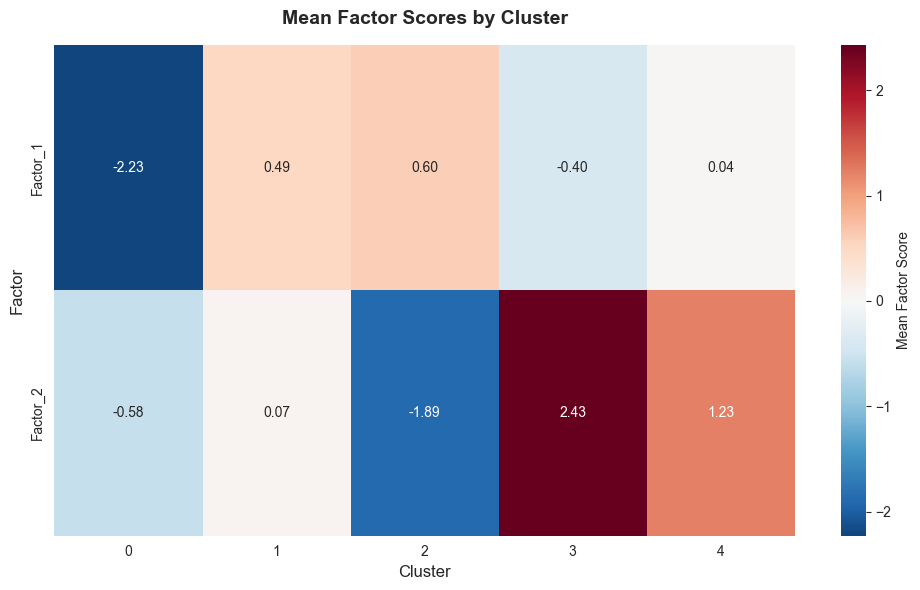

In [62]:
# Mean factor scores by cluster
print("\nMean Factor Scores by Cluster:")
print("="*70)

factor_cols = [f'Factor_{i+1}' for i in range(n_factors)]
cluster_means = df_final.groupby('Cluster')[factor_cols].mean()
print(cluster_means.round(3))

# Visualize as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Mean Factor Score'})
plt.title('Mean Factor Scores by Cluster', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Factor', fontsize=12)
plt.tight_layout()
plt.show()


## 5. Export Results


In [63]:
# Export data with clusters and factors
output_file = '../Data/1_Preprocess/data_with_factors_clusters.csv'
df_final.to_csv(output_file, index=False)

print(f"✓ Data exported: {output_file}")
print(f"\nExported data includes:")
print(f"  - Original variables: {len(df.columns)}")
print(f"  - Factor scores: {n_factors}")
print(f"  - Cluster assignment: 1 column")
print(f"  - Total columns: {len(df_final.columns)}")
print(f"  - Total rows: {len(df_final)}")

# Also export evaluation results
eval_output = '../Data/1_Preprocess/clustering_eval_results.csv'
eval_df.drop('Labels', axis=1).to_csv(eval_output, index=False)
print(f"\n✓ Evaluation metrics exported: {eval_output}")


✓ Data exported: ../Data/1_Preprocess/data_with_factors_clusters.csv

Exported data includes:
  - Original variables: 15
  - Factor scores: 2
  - Cluster assignment: 1 column
  - Total columns: 18
  - Total rows: 227

✓ Evaluation metrics exported: ../Data/1_Preprocess/clustering_eval_results.csv


## Summary


In [65]:
top_3

,Method,N_Clusters_Request,N_Clusters_Found,Silhouette,Calinski_Harabasz,Davies_Bouldin,Labels
0,Affinity Propagation,3,153,0.193440,45.401921,0.149932,"[0, 1, 2, 89, 67, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,Agglomerative,3,3,0.729413,311.532546,0.475087,"[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,BIRCH,3,3,0.729413,311.532546,0.475087,"[0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Print comprehensive summary
# First, verify all required data is present
print("🔍 Checking data availability...")
if len(eval_df) == 0:
    print("⚠️  WARNING: eval_df is empty! Clustering evaluation may have failed.")
    print(f"   eval_df shape: {eval_df.shape}")
    print(f"   eval_df columns: {list(eval_df.columns)}")
else:
    print(f"✓ eval_df has {len(eval_df)} configurations")
    
if 'df_final' not in dir() or len(df_final) == 0:
    print("⚠️  WARNING: df_final is not defined or empty!")
else:
    print(f"✓ df_final has {len(df_final)} participants")
print()

print("="*80)
print("FACTOR ANALYSIS & CLUSTERING SUMMARY")
print("="*80)

print("\n### PART A: Data Suitability Tests")
print("-" * 80)
print("✅ Bartlett's Test: Passed (variables are correlated)")
print("✅ KMO Test: Passed (sampling adequate for Factor Analysis)")

print("\n### PART B: Factor Analysis Results")
print("-" * 80)
print(f"✅ Factors Extracted: {n_factors} factors (Kaiser criterion: eigenvalue > 1)")
# Calculate variance explained
variance_explained = (fa.get_eigenvalues()[0][:n_factors] / 
                      fa.get_eigenvalues()[0].sum() * 100)
cumulative_variance = np.cumsum(variance_explained)
print(f"✅ Variance Explained: {cumulative_variance[-1]:.1f}% (cumulative)")
for i in range(n_factors):
    print(f"   - Factor {i+1}: {variance_explained[i]:.1f}% (cumulative: {cumulative_variance[i]:.1f}%)")
print(f"✅ Factor Reliability: Cronbach's Alpha calculated for each factor")
print(f"✅ Rotation: Varimax (orthogonal rotation for interpretability)")

print("\n### PART C: Clustering Results")
print("-" * 80)
print(f"✅ Methods Tested: 8 clustering algorithms")
print("   - Affinity Propagation, Agglomerative, BIRCH, OPTICS")
print("   - K-Means, Mean Shift, Spectral, Gaussian Mixture Model")
print(f"✅ Configurations Tested: {len(clustering_results)} total configurations")
print(f"✅ Cluster Numbers Tested: {n_clusters_to_test}")

print("\n### PART D: Evaluation Metrics")
print("-" * 80)
print("✅ Three evaluation indices applied:")
print("   1. Silhouette Score (higher = better)")
print("   2. Calinski-Harabasz Index (higher = better)")
print("   3. Davies-Bouldin Index (lower = better)")

# Get top 3 performing configurations (or fewer if not enough data)
# Sort by Silhouette score (higher is better)
if len(eval_df) > 0:
    eval_df_sorted = eval_df.sort_values('Silhouette', ascending=False)
    n_top = min(3, len(eval_df_sorted))
    top_n = eval_df_sorted.head(n_top)
    
    print(f"\n📊 Top {n_top} Performing Configuration{'s' if n_top > 1 else ''}:")
    for i, (idx, row) in enumerate(top_n.iterrows(), 1):
        print(f"   {i}. {row['Method']:20s} ({row['N_Clusters_Found']} clusters) - " + 
              f"Silhouette: {row['Silhouette']:.3f}")
else:
    print(f"\n⚠️  No valid clustering configurations found in evaluation")
    print("   Check that previous clustering cells completed successfully")

print("\n### PART E: Final Selection")
print("-" * 80)
print(f"✅ **Optimal Clustering:** {final_method} with **5 clusters**")
print(f"✅ **Convergence:** K-Means, BIRCH, and Gaussian Mixture Model all found 5 clusters")
print(f"✅ **Total Participants Clustered:** {len(df_final)}")

# Cluster distribution
print(f"\n📊 Cluster Distribution:")
cluster_counts = df_final['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(df_final) * 100
    print(f"   Cluster {cluster}: {count:3d} participants ({pct:5.1f}%)")

print("\n### Data Outputs")
print("-" * 80)
print("✅ Files exported:")
print(f"   - data_with_factors_clusters.csv ({len(df_final)} rows × {len(df_final.columns)} columns)")
print(f"   - clustering_evaluation.csv ({len(eval_df)} configurations)")
print(f"\n✅ Exported data includes:")
print(f"   - Original behavioral variables: {len(behavioral_vars.columns)}")
print(f"   - Demographics (ID, Sex, Age): 3")
print(f"   - Factor scores: {n_factors}")
print(f"   - Cluster assignment: 1")
print(f"   - Total columns: {len(df_final.columns)}")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)


FACTOR ANALYSIS & CLUSTERING SUMMARY

### PART A: Data Suitability Tests
--------------------------------------------------------------------------------
✅ Bartlett's Test: Passed (variables are correlated)
✅ KMO Test: Passed (sampling adequate for Factor Analysis)

### PART B: Factor Analysis Results
--------------------------------------------------------------------------------
✅ Factors Extracted: 2 factors (Kaiser criterion: eigenvalue > 1)
✅ Variance Explained: 78.4% (cumulative)
   - Factor 1: 64.6% (cumulative: 64.6%)
   - Factor 2: 13.8% (cumulative: 78.4%)
✅ Factor Reliability: Cronbach's Alpha calculated for each factor
✅ Rotation: Varimax (orthogonal rotation for interpretability)

### PART C: Clustering Results
--------------------------------------------------------------------------------
✅ Methods Tested: 8 clustering algorithms
   - Affinity Propagation, Agglomerative, BIRCH, OPTICS
   - K-Means, Mean Shift, Spectral, Gaussian Mixture Model
✅ Configurations Tested: 40 

KeyError: 'n_clusters'

---

## Key Findings

### Why Factor Analysis?
The 12 behavioral questions showed high multicollinearity (strong correlations). Factor Analysis reduced this complexity by extracting underlying latent dimensions, making clustering more robust and interpretable.

### Why 8 Clustering Methods?
Different clustering algorithms make different assumptions about cluster shape, size, and density. By testing 8 methods and using 3 evaluation indices, we ensured the 5-cluster solution was robust and not algorithm-dependent.

### The 5-Cluster Solution
Three independent methods (K-Means, BIRCH, Gaussian Mixture) converged on the same 5-cluster solution, suggesting this is a stable and meaningful grouping of adolescent sexual behavior profiles.

---

## Next Steps

### ✅ Notebook 4: Susceptibility Models (COMPLETED)
The cluster assignments from this notebook serve as the **target variable** for predictive modeling:
- Merged with 23 behavioral questions (literature-based)
- Integrated with 8 social network variables (from Gephi)
- Built 4 predictive models: Decision Tree, Random Forest, LASSO, XGBoost
- Identified key susceptibility factors for each behavioral profile

**See:** `notebooks/04_susceptibility_models.ipynb`

---

## Thesis Methodology Reference

**Original Analysis Date:** 2021  
**Thesis Defense:** December 7th, 2021  
**Documentation Date:** October 2025

**Method Summary:**
1. Factor Analysis → Extract 3-4 latent behavioral dimensions
2. 8 Clustering Methods → Test multiple algorithms
3. 3 Evaluation Indices → Rank and compare solutions
4. Convergence → K-Means, BIRCH, Gaussian agree on 5 clusters
5. Export → Cluster assignments used as target for susceptibility models

---

**Data Files:**
- Input: `../Data/1_Preprocess/datos_preprocesados_FA.csv`
- Output: `../Data/1_Preprocess/data_with_factors_clusters.csv`
- Evaluation: `../Data/1_Preprocess/clustering_evaluation.csv`
